In [1]:
#%%file IBP/generate_data.py

from __future__ import division
import numpy as np
import os
import math

np.random.seed(123)

#weights matrix
A=np.array([[1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
   [0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0],
   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,1,1,1]])

#data simulation
N=100
D=36
 
true_sig_x=0.5

true_Z=np.zeros((N,4))
X=np.zeros((N,D))

for i in range(N):
    true_Z[i,:]=(np.random.rand(4)>0.5)
    while sum(true_Z[i,:])==0:
        true_Z[i,:]=(np.random.rand(4)>0.5)
    X[i,:]=np.dot(np.random.normal(0,1,D), np.diag([true_sig_x]*D))+np.dot(true_Z[i,:] , A)

#creating folder if not present
if not os.path.exists('data_files'):
    os.makedirs('data_files')

#saving simulated data    
np.savetxt('data_files/true_Z.csv', true_Z, delimiter=',')
np.savetxt('data_files/true_X.csv', X, delimiter=',')
np.savetxt('data_files/true_A.csv', A, delimiter=',')

In [2]:
%%file IBP/new_Kold.py

from __future__ import division
import numpy as np
import numpy.linalg
import math
from .likelihood_old import full_X_old
#sample the number of new dishes
np.random.seed(123)

def new_Kold(alpha,X,N,Z,s_x,s_a,obj):
    k_prob = np.zeros(5)
    for i in range(0,5):
        l = alpha/N
        new_zi = np.zeros((N,i))
        new_zi[obj,:] = np.ones((1,i))
        new_Z = np.hstack([Z,new_zi.reshape(N,i)])
        LH = full_X_old(new_Z,X,s_x, s_a)
        log_prior = i*np.log(l)-l-np.log(math.factorial(i))
        k_prob[i] = LH + log_prior#likelihood*prior = posterior
 
    k_prob = np.exp(k_prob-max(k_prob))
    k_prob = k_prob/sum(k_prob)
    if (abs(sum(k_prob)-1)>0.001):
        return(sum(k_prob),'wrong k sum')
    
    new_k = np.random.choice(5,1,p = k_prob)
    return (new_k)

Overwriting IBP/new_Kold.py


In [3]:
%%file IBP/new_K.py

from __future__ import division
import numpy as np
import numpy.linalg
import math
from .likelihood import full_X
#sample the number of new dishes
np.random.seed(123)

def new_K(alpha,X,N,Z,s_x,s_a,obj):
    k_prob = np.zeros(5)
    for i in range(0,5):
        l = alpha/N
        new_zi = np.zeros((N,i))
        new_zi[obj,:] = np.ones((1,i))
        new_Z = np.hstack([Z,new_zi.reshape(N,i)])
        LH = full_X(new_Z,X,s_x, s_a)
        log_prior = i*np.log(l)-l-np.log(math.factorial(i))
        k_prob[i] = LH + log_prior#likelihood*prior = posterior
 
    k_prob = np.exp(k_prob-max(k_prob))
    k_prob = k_prob/sum(k_prob)
    if (abs(sum(k_prob)-1)>0.001):
        return(sum(k_prob),'wrong k sum')
    
    new_k = np.random.choice(5,1,p = k_prob)
    return (new_k)

Overwriting IBP/new_K.py


In [4]:
%%file IBP/likelihood_old.py

from __future__ import division
import numpy as np
import numpy.linalg
import math

#compute likelihood
np.random.seed(123)
def full_X_old(Z,X,s_x,s_a):
    D = X.shape[1]
    N = Z.shape[0]
    K = Z.shape[1]
    """The constant part"""
    zz = np.dot(Z.T,Z)+np.diag([(s_x**2)/(s_a**2)]*K) #zz -- K*K
    determ = np.linalg.det(zz)
    log_const = 0.5*N*D*np.log(2*np.pi)+(N-K)*D*np.log(s_x)+K*D*np.log(s_a)+0.5*D*np.log(determ)
    log_const = -log_const
    """The exponential part"""
    L = np.linalg.cholesky(zz)
    inv_L = np.linalg.inv(L)
    ii =  np.eye(N)-np.dot(np.dot(np.dot(Z , inv_L.T), inv_L) , Z.T)
    tr =  np.trace(np.dot(np.dot(X.T , ii) ,X))
    expon = -tr/(2*s_x**2)
    return(log_const+expon)

Overwriting IBP/likelihood_old.py


In [5]:
%%file IBP/likelihood.py

from __future__ import division
import numpy as np
import numpy.linalg
import math

#compute likelihood
np.random.seed(123)
def full_X(Z,X,s_x,s_a):
    D = X.shape[1]
    N = Z.shape[0]
    K = Z.shape[1]
    """The constant part"""
    zz = np.dot(Z.T,Z)+((s_x**2)/(s_a**2))*np.eye(K) #zz -- K*K
    determ = np.linalg.det(zz)
    log_const = 0.5*N*D*np.log(2*np.pi)+(N-K)*D*np.log(s_x)+K*D*np.log(s_a)+0.5*D*np.log(determ)
    log_const = -log_const
    """The exponential part"""
    ii =  np.eye(N)-np.dot(np.dot(Z , np.linalg.inv(zz)) , Z.T)
    tr =  np.trace(np.dot(np.dot(X.T , ii) ,X))
    expon = -tr/(2*s_x**2)
    return(log_const+expon)

Overwriting IBP/likelihood.py


In [6]:
%%file IBP/gibbs.py

from __future__ import division
import numpy as np
import numpy.linalg
import math
from IBP import new_K
from IBP import full_X 

np.random.seed(123)

def gibbs_sampler(X,init_alpha,init_sig_x,init_sig_a,mcmc):
    N = X.shape[0]
    chain_alpha = np.zeros(mcmc)
    chain_sigma_a = np.zeros(mcmc)
    chain_sigma_x = np.zeros(mcmc)
    chain_K = np.zeros(mcmc)
    chain_Z = list()
    #initial matrix Z
    Z = np.array(np.random.choice(2,N,p = [0.5,0.5])).reshape(N,1)

    chain_alpha[0] = alpha = init_alpha 
    chain_sigma_a[0] = sigma_a = init_sig_a 
    chain_sigma_x[0] = sigma_x = init_sig_x
    chain_K[0] = K = 1
    chain_Z.append(Z)
    P = np.zeros(2)
    
    Hn = 0
    for i in range(1,mcmc):
        #gibbs
        alpha = np.random.gamma(1+K,1/(1+Hn))
        print(i,K)
        Hn = 0
        for im in range(0,N): #loop over images
            Hn = Hn + 1/(im+1)
            #sample new Z_i
            for k in range(0,K):#loop over features
                zk_sum = np.sum(Z[:,k])
                if zk_sum == 0:
                     lz = -10**5
                else:
                     lz = np.log(zk_sum)-np.log(N)
                if zk_sum == N:
                     lz0 = -10**5
                else:
                     lz0 = np.log(N-zk_sum)-np.log(N)
                Z[im,k] = 1
                P[0] = full_X(Z,X,sigma_x,sigma_a)+lz
                Z[im,k] = 0
                P[1] = full_X(Z,X,sigma_x,sigma_a)+lz0

                P=np.exp(P - max(P))
                P[0] = P[0]/(P[0]+P[1])
                if np.random.uniform(0,1,1)<P[0]:
                    Z[im,k] = 1
                else:
                    Z[im,k] = 0

            #sample K---num of new features
            new_k = new_K(alpha,X,N,Z,sigma_x,sigma_a,im)[0]
            if Z.shape[1]>(K+new_k):
                Ztemp=Z
                Ztemp[im,K:(K+new_k)]=1       
            else:
                Ztemp=np.zeros((Z.shape[0],K+new_k))
                Ztemp[0:Z.shape[0],0:Z.shape[1]]=Z
                Ztemp[im,K:(K+new_k)] = 1

            Z=Ztemp
            K = K + new_k

            #sample a new sigma_x and sigma_a with MH,invgamma(2,2) prior/invgamma(1,1) proposal
            #for mh in range(0,5):
            '''propose new sigma_x'''
            current_LH = full_X(Z,X,sigma_x,sigma_a)
            #sig_x_str = sigma_x + (np.random.rand(1)[0]-0.5)
            sig_x_str = 1/np.random.gamma(3,2)#propose a new sigma_x from invgamma(3,2)
            pos_str = full_X(Z,X,sig_x_str,sigma_a)-3*np.log(sig_x_str)-1/(2*sig_x_str)
            pos = current_LH-3*np.log(sigma_x)-1/(2*sigma_x)
            if((pos_str-pos)>0):
                sigma_x = sig_x_str
            else:
                move = np.random.rand(1)
                if(np.log(move[0]) < (pos_str-pos)):
                    sigma_x = sig_x_str
                '''propose new sigma_a'''
            #sig_a_str = sigma_a + (np.random.rand(1)[0]-0.5)
            sig_a_str = 1/np.random.gamma(3,2)
            pos_str = full_X(Z,X,sigma_x,sig_a_str)-3*np.log(sig_a_str)-1/(2*sig_a_str)
            pos = current_LH-3*np.log(sigma_a)-1/(2*sigma_a)
            if((pos_str-pos) > 0):
                sigma_a = sig_a_str
            else:
                move = np.random.rand(1)
                if(np.log(move[0]) < (pos_str-pos)):
                    sigma_a = sig_a_str

        #remove features that have only 1 object
        index = np.sum(Z,0)>1
        Z = Z[:,index]
        K = Z.shape[1]

        #store chain values                
        chain_alpha[i] = alpha
        chain_sigma_a[i] = sigma_a
        chain_sigma_x[i] = sigma_x
        chain_K[i] = K
        chain_Z.append(Z)
        
    return(chain_alpha,chain_sigma_a,chain_sigma_x,chain_K,chain_Z)


Overwriting IBP/gibbs.py


## Profile

In [7]:
import profile
import pstats
from IBP import gibbs_sampler
filename = 'profile_orig.stats'
profile.run('gibbs_sampler(X,1,0.5,1.7,100)',filename)
stats = pstats.Stats('profile_orig.stats')

stats.sort_stats('time')
stats.print_stats()

(1, 1)
(2, 3)
(3, 3)
(4, 3)
(5, 3)
(6, 3)
(7, 3)
(8, 3)
(9, 3)
(10, 3)
(11, 3)
(12, 3)
(13, 4)
(14, 4)
(15, 4)
(16, 4)
(17, 4)
(18, 4)
(19, 4)
(20, 4)
(21, 4)
(22, 4)
(23, 4)
(24, 4)
(25, 4)
(26, 5)
(27, 5)
(28, 5)
(29, 5)
(30, 5)
(31, 5)
(32, 5)
(33, 4)
(34, 4)
(35, 4)
(36, 4)
(37, 5)
(38, 5)
(39, 5)
(40, 6)
(41, 5)
(42, 5)
(43, 5)
(44, 5)
(45, 4)
(46, 5)
(47, 4)
(48, 4)
(49, 4)
(50, 4)
(51, 4)
(52, 4)
(53, 4)
(54, 4)
(55, 4)
(56, 5)
(57, 4)
(58, 5)
(59, 4)
(60, 4)
(61, 5)
(62, 4)
(63, 4)
(64, 5)
(65, 4)
(66, 4)
(67, 4)
(68, 4)
(69, 4)
(70, 4)
(71, 4)
(72, 4)
(73, 4)
(74, 4)
(75, 4)
(76, 4)
(77, 4)
(78, 4)
(79, 4)
(80, 4)
(81, 5)
(82, 5)
(83, 5)
(84, 5)
(85, 5)
(86, 4)
(87, 4)
(88, 4)
(89, 4)
(90, 4)
(91, 4)
(92, 4)
(93, 4)
(94, 4)
(95, 4)
(96, 4)
(97, 4)
(98, 4)
(99, 4)
Mon Apr 30 15:52:02 2018    profile_orig.stats

         10063485 function calls in 152.897 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   846230   24

<pstats.Stats instance at 0x10cbc7ef0>

## Count time of 1000 interations

In [8]:
from IBP import gibbs_sampler
import time

t0 = time.time()
chain_alpha1,chain_sigma_a1,chain_sigma_x1,chain_K1,chain_Z1 = gibbs_sampler(X,init_alpha=1,init_sig_x=0.5,init_sig_a=1.7,mcmc=1000)
t1 = time.time()
total=t1-t0

(1, 1)
(2, 3)
(3, 3)
(4, 3)
(5, 3)
(6, 4)
(7, 4)
(8, 4)
(9, 4)
(10, 5)
(11, 5)
(12, 5)
(13, 4)
(14, 4)
(15, 4)
(16, 4)
(17, 4)
(18, 5)
(19, 5)
(20, 5)
(21, 5)
(22, 5)
(23, 5)
(24, 5)
(25, 5)
(26, 5)
(27, 5)
(28, 6)
(29, 6)
(30, 7)
(31, 6)
(32, 6)
(33, 6)
(34, 6)
(35, 5)
(36, 5)
(37, 5)
(38, 5)
(39, 5)
(40, 5)
(41, 6)
(42, 5)
(43, 5)
(44, 5)
(45, 5)
(46, 5)
(47, 5)
(48, 5)
(49, 5)
(50, 5)
(51, 5)
(52, 5)
(53, 7)
(54, 7)
(55, 6)
(56, 5)
(57, 6)
(58, 5)
(59, 5)
(60, 5)
(61, 6)
(62, 6)
(63, 6)
(64, 6)
(65, 6)
(66, 6)
(67, 6)
(68, 6)
(69, 7)
(70, 6)
(71, 6)
(72, 6)
(73, 6)
(74, 7)
(75, 6)
(76, 7)
(77, 8)
(78, 7)
(79, 7)
(80, 6)
(81, 5)
(82, 5)
(83, 5)
(84, 5)
(85, 5)
(86, 5)
(87, 5)
(88, 6)
(89, 6)
(90, 5)
(91, 5)
(92, 5)
(93, 5)
(94, 5)
(95, 5)
(96, 5)
(97, 6)
(98, 7)
(99, 6)
(100, 7)
(101, 7)
(102, 7)
(103, 6)
(104, 6)
(105, 6)
(106, 6)
(107, 8)
(108, 8)
(109, 8)
(110, 7)
(111, 7)
(112, 7)
(113, 7)
(114, 9)
(115, 6)
(116, 6)
(117, 6)
(118, 6)
(119, 6)
(120, 6)
(121, 6)
(122, 6)
(123, 6)
(

(924, 5)
(925, 5)
(926, 5)
(927, 5)
(928, 5)
(929, 5)
(930, 6)
(931, 5)
(932, 5)
(933, 5)
(934, 5)
(935, 5)
(936, 5)
(937, 5)
(938, 6)
(939, 5)
(940, 6)
(941, 5)
(942, 5)
(943, 5)
(944, 5)
(945, 5)
(946, 6)
(947, 6)
(948, 5)
(949, 5)
(950, 5)
(951, 5)
(952, 6)
(953, 6)
(954, 5)
(955, 5)
(956, 6)
(957, 5)
(958, 5)
(959, 5)
(960, 5)
(961, 5)
(962, 5)
(963, 5)
(964, 5)
(965, 5)
(966, 5)
(967, 5)
(968, 5)
(969, 8)
(970, 6)
(971, 5)
(972, 5)
(973, 5)
(974, 5)
(975, 5)
(976, 5)
(977, 6)
(978, 6)
(979, 6)
(980, 5)
(981, 5)
(982, 5)
(983, 5)
(984, 5)
(985, 6)
(986, 7)
(987, 6)
(988, 7)
(989, 7)
(990, 7)
(991, 7)
(992, 7)
(993, 5)
(994, 5)
(995, 5)
(996, 6)
(997, 6)
(998, 5)
(999, 6)


In [9]:
total

463.24201488494873

## Optimization 
Cython, Cythonize, JIT and Multiprocessing were tried to further optimize the Gibbs Sampler. Codes are presented separately in their own notebooks.

## Figures and Plots

In [15]:
#creating folder if not present
if not os.path.exists('data_files'):
    os.makedirs('data_files')

#np.save('data_files/chain_Z', chain_Z)
np.save('data_files/chain_K', chain_K1)
np.save('data_files/chain_sigma_A', chain_sigma_a1)
np.save('data_files/chain_sigma_X', chain_sigma_x1)
np.save('data_files/chain_alpha', chain_alpha1)


In [16]:
#trace plot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy.testing as npt
%matplotlib inline
%precision 4
plt.style.use('ggplot')

In [17]:
Z=chain_Z1[999].reshape(100,4)
sigma_X=chain_sigma_x1[999]
sigma_A=chain_sigma_a1[999]

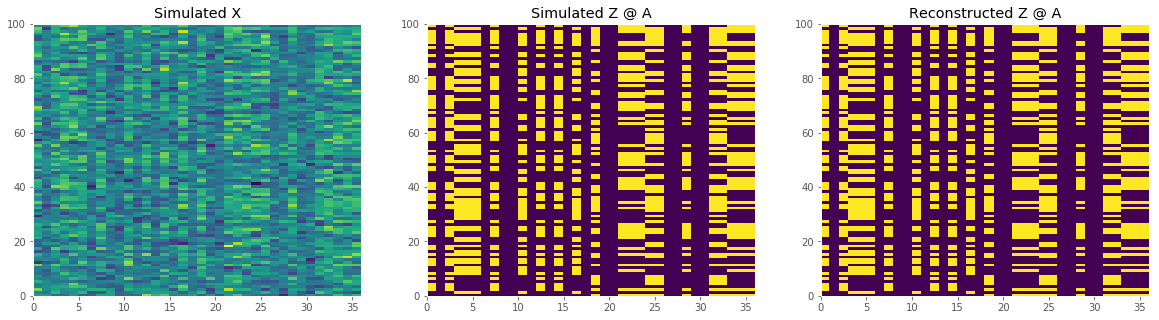

In [18]:
f = plt.figure()
f.set_size_inches(20,5)
plt.subplot(1,3,1)
plt.pcolormesh(X)
plt.title('Simulated X')
plt.subplot(1,3,2)
plt.pcolormesh(np.dot(Z,A))
plt.title('Simulated Z @ A')
plt.subplot(1,3,3)
plt.pcolormesh(np.dot(Z,A))
plt.title('Reconstructed Z @ A')
plt.savefig('data_files/realization.png')

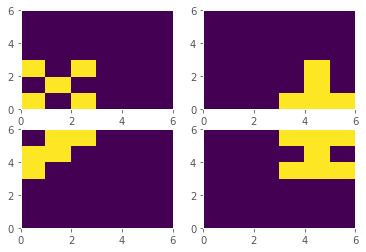

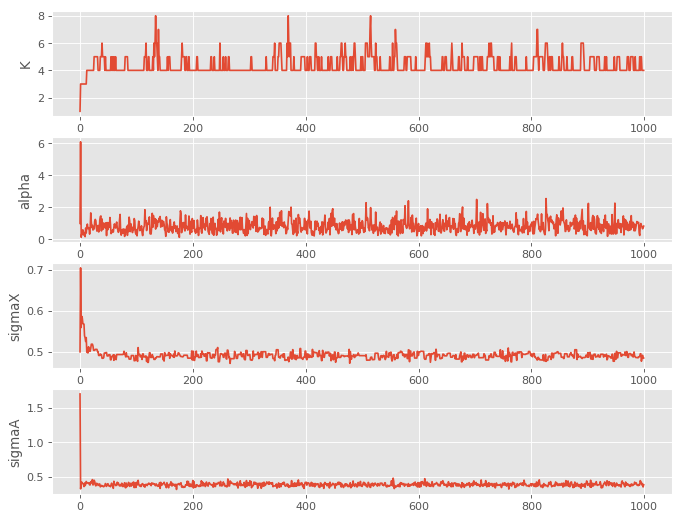

In [19]:
chain_K=np.load('data_files/chain_K.npy')
chain_sigma_X=np.load('data_files/chain_sigma_X.npy')
chain_sigma_A=np.load('data_files/chain_sigma_A.npy')
chain_alpha=np.load('data_files/chain_alpha.npy')

#obtaining feature images
A_fig = plt.figure()
plt.subplot(2,2,1)
plt.pcolormesh(A[0,:].reshape(6,6))
plt.subplot(2,2,2)
plt.pcolormesh(A[1,:].reshape(6,6))
plt.subplot(2,2,3)
plt.pcolormesh(A[2,:].reshape(6,6))
plt.subplot(2,2,4)
plt.pcolormesh(A[3,:].reshape(6,6))
plt.savefig('data_files/features.png')

#making trace plots
plt.figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(411)
plt.plot(chain_K)
plt.ylabel('K')
plt.subplot(412)
plt.plot(chain_alpha)
plt.ylabel('alpha')
plt.subplot(413)
plt.plot(chain_sigma_X)
plt.ylabel('sigmaX')
plt.subplot(414)
plt.plot(chain_sigma_A)
plt.ylabel('sigmaA')
plt.savefig('data_files/trace_plots.png')

###  Four most requently presented features

In [20]:
A_inf=np.dot(np.dot(np.linalg.inv((np.dot(Z.T,Z)+(sigma_X/sigma_A)*np.eye(4))),Z.T),X)

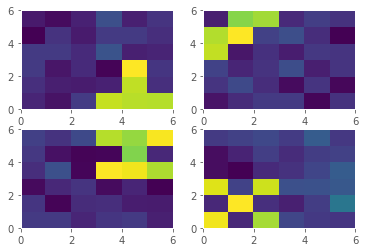

In [21]:
A_inf_fig = plt.figure()
plt.subplot(2,2,1)
plt.pcolormesh(A_inf[0,:].reshape(6,6))
plt.subplot(2,2,2)
plt.pcolormesh(A_inf[1,:].reshape(6,6))
plt.subplot(2,2,3)
plt.pcolormesh(A_inf[2,:].reshape(6,6))
plt.subplot(2,2,4)
plt.pcolormesh(A_inf[3,:].reshape(6,6))

### Reconstructed features

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


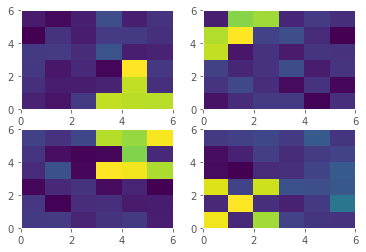

In [22]:
recon_A = np.linalg.lstsq(Z,X)[0]
recon_A_fig = plt.figure()
plt.subplot(2,2,1)
plt.pcolormesh(recon_A[0,:].reshape(6,6))
plt.subplot(2,2,2)
plt.pcolormesh(recon_A[1,:].reshape(6,6))
plt.subplot(2,2,3)
plt.pcolormesh(recon_A[2,:].reshape(6,6))
plt.subplot(2,2,4)
plt.pcolormesh(recon_A[3,:].reshape(6,6))
plt.savefig('data_files/reconstructed_features.png')